# IT-Domain NER (5-entity) — Full FT vs LoRA (PEFT) vs DistilBERT + optional ONNX
This notebook runs everything **without subprocess / `python -m ...`**. It calls project functions directly: `prepare_dataset()`, `train_run()`, `eval_run()`, `export_run()`.


In [1]:
# ===== 0) Setup (imports + helpers) =====
import os, json, math, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project API (callable functions, no subprocess)
from src.data import prepare_dataset
from src.train import train_run
from src.eval import eval_run

# Optional export (ONNX). Safe to import; heavy deps are checked inside.
from src.export import export_run

from datasets import load_from_disk


In [2]:
# ===== 1) Load config + prepare folders =====
from pathlib import Path
import os

ROOT = Path("..").resolve()
CFG_PATH = ROOT / "configs" / "base.yaml"

print("ROOT:", ROOT)
print("CFG:", CFG_PATH)

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")


ROOT: C:\Users\alenk\Downloads\it-ner-peft-compression
CFG: C:\Users\alenk\Downloads\it-ner-peft-compression\configs\base.yaml


'false'

In [3]:
# ===== 2) Prepare dataset (cached) =====
meta = prepare_dataset(root=ROOT, dataset_name="mrm8488/stackoverflow-ner", force_redownload=False)

print("Dataset:", meta["dataset"])
print("New labels:", meta["new_label_names"])
cov = meta["mapping_coverage"]
mapped = cov.get("mapped_count")
total = cov.get("total_count")
ratio = cov.get("coverage_ratio")
print(f"Mapping coverage: {mapped}/{total} (ratio={ratio:.3f}) | mode={cov.get('mode')}")


2026-01-27 12:44:57,944 | INFO | Starting dataset preparation
2026-01-27 12:44:57,945 | INFO | Dataset: mrm8488/stackoverflow-ner
2026-01-27 12:44:57,945 | INFO | Downloading dataset from HuggingFace
2026-01-27 12:45:02,943 | INFO | Saving raw dataset to: C:\Users\alenk\Downloads\it-ner-peft-compression\data\raw\mrm8488__stackoverflow-ner


Saving the dataset (0/1 shards):   0%|          | 0/9263 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3108 [00:00<?, ? examples/s]

2026-01-27 12:45:03,451 | INFO | Remapping labels to 5-entity schema (mode=str)
2026-01-27 12:45:04,594 | INFO | Saving processed dataset to: C:\Users\alenk\Downloads\it-ner-peft-compression\data\processed\mrm8488__stackoverflow-ner


Saving the dataset (0/1 shards):   0%|          | 0/9263 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3108 [00:00<?, ? examples/s]

2026-01-27 12:45:04,677 | INFO | Done
2026-01-27 12:45:04,678 | WARNING | Low mapping coverage (ratio=0.286). Consider expanding keyword rules.


Dataset: mrm8488/stackoverflow-ner
New labels: ['O', 'B-ERROR', 'B-HARDWARE', 'B-OS', 'B-SOFTWARE', 'B-VERSION', 'I-ERROR', 'I-HARDWARE', 'I-OS', 'I-SOFTWARE', 'I-VERSION']
Mapping coverage: 14/49 (ratio=0.286) | mode=str


In [4]:
# ===== 3) Load processed dataset for EDA =====
from src.paths import ProjectPaths, ds_key

paths = ProjectPaths.from_root(ROOT)
key = ds_key(meta["dataset"])
ds_path = paths.processed_data / key
ds = load_from_disk(str(ds_path))

print({k: len(v) for k,v in ds.items()})


{'train': 9263, 'validation': 2936, 'test': 3108}


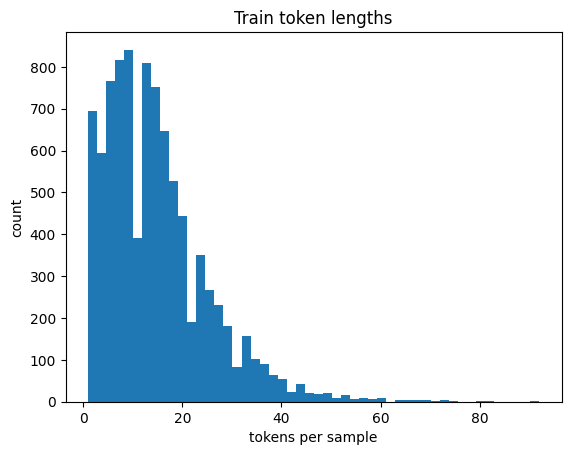

,label,count
0,O,132983
4,B-SOFTWARE,2766
9,I-SOFTWARE,422
5,B-VERSION,257
2,B-HARDWARE,199
3,B-OS,171
1,B-ERROR,61
6,I-ERROR,53
7,I-HARDWARE,46
8,I-OS,21


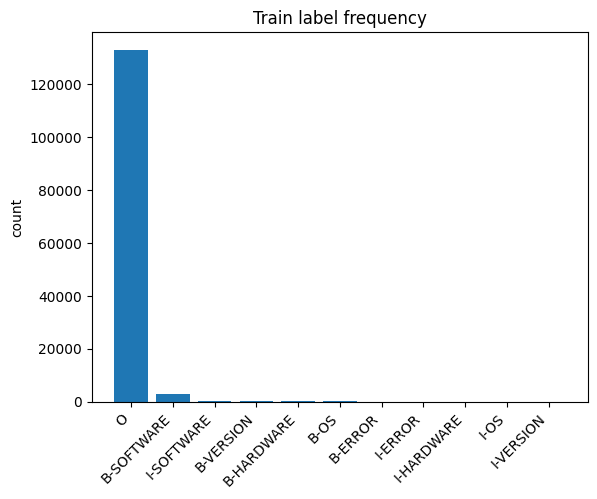

Non-O tokens: 4013/136996 = 0.029


In [5]:
# ===== 4) EDA: token lengths + label distribution =====
label_names = meta["new_label_names"]
label2id = {n:i for i,n in enumerate(label_names)}

# Token length distribution (train)
lens = [len(x) for x in ds["train"]["tokens"]]
plt.figure()
plt.hist(lens, bins=50)
plt.title("Train token lengths")
plt.xlabel("tokens per sample")
plt.ylabel("count")
plt.show()

# Label distribution (train)
counts = {n:0 for n in label_names}
for seq in ds["train"]["ner_tags"]:
    for t in seq:
        counts[label_names[int(t)]] += 1

df_counts = pd.DataFrame({"label": list(counts.keys()), "count": list(counts.values())})
df_counts = df_counts.sort_values("count", ascending=False)
display(df_counts)

plt.figure()
plt.bar(df_counts["label"], df_counts["count"])
plt.title("Train label frequency")
plt.xticks(rotation=45, ha="right")
plt.ylabel("count")
plt.show()

# Non-O ratio
non_o = sum(v for k,v in counts.items() if k!="O")
total = sum(counts.values())
print(f"Non-O tokens: {non_o}/{total} = {non_o/total:.3f}")


In [6]:
# ===== 5) Train runs (GPU-friendly defaults, saves to models/<run>/) =====
# NOTE: Runs are defined in src/train.py: bert_full, bert_lora, distil_full

RUNS = ["bert_lora", "distil_full", "bert_full"]  # reorder as you like
train_summaries = {}

for r in RUNS:
    print("\n" + "="*80)
    print("TRAIN:", r)
    out = train_run(run=r, config_path=str(CFG_PATH), root=ROOT, force_cpu=False)
    train_summaries[r] = out
    print("Saved to:", out["run_dir"])
    print("Train metrics keys:", list(out["train_metrics"].keys())[:10])


2026-01-27 13:02:25,924 | WARNING | Could not backup existing run dir (C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora). Will reuse/overwrite. Error: [WinError 5] Отказано в доступе: 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_lora' -> 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_lora__bak__20260127_130225'
2026-01-27 13:02:26,074 | INFO | Run: bert_lora
2026-01-27 13:02:26,074 | INFO | Base model: bert-base-cased
2026-01-27 13:02:26,075 | INFO | Use LoRA: True
2026-01-27 13:02:26,076 | INFO | Dataset: mrm8488/stackoverflow-ner
2026-01-27 13:02:26,077 | INFO | CUDA: True | fp16: True | tf32: True | grad_ckpt: True



TRAIN: bert_lora


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-01-27 13:02:27,770 | INFO | Tokenizing train split: 9263 samples


trainable params: 303,371 || all params: 108,031,510 || trainable%: 0.2808


Map:   0%|          | 0/9263 [00:00<?, ? examples/s]

2026-01-27 13:02:29,295 | INFO | Tokenizing eval split: 2936 samples


Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

2026-01-27 13:02:29,808 | INFO | Trying batch_size=8 grad_accum=2 (effective=16)
2026-01-27 13:02:30,779 | INFO | Training start


Epoch,Training Loss,Validation Loss
1,0.137400,0.173171
2,0.102700,0.125346
3,0.078400,0.117276
4,0.085900,0.114726
5,0.074400,0.113613


2026-01-27 13:14:43,297 | INFO | Training done
2026-01-27 13:14:43,299 | INFO | Eval start


2026-01-27 13:15:05,641 | INFO | Eval done
2026-01-27 13:15:05,641 | INFO | Saving model to C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora
2026-01-27 13:15:06,192 | INFO | Training succeeded with batch_size=8 grad_accum=2
2026-01-27 13:15:06,195 | INFO | Done
2026-01-27 13:15:06,220 | WARNING | Could not backup existing run dir (C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full). Will reuse/overwrite. Error: [WinError 5] Отказано в доступе: 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\distil_full' -> 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\distil_full__bak__20260127_131506'
2026-01-27 13:15:06,227 | INFO | Run: distil_full
2026-01-27 13:15:06,228 | INFO | Base model: distilbert-base-cased
2026-01-27 13:15:06,229 | INFO | Use LoRA: False
2026-01-27 13:15:06,230 | INFO | Dataset: mrm8488/stackoverflow-ner
2026-01-27 13:15:06,230 | INFO | CUDA: True | fp16: True | tf32: True | grad_ckpt: True


Saved to: C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora
Train metrics keys: ['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch']

TRAIN: distil_full


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-01-27 13:15:07,891 | INFO | Tokenizing train split: 9263 samples


Map:   0%|          | 0/9263 [00:00<?, ? examples/s]

2026-01-27 13:15:09,538 | INFO | Tokenizing eval split: 2936 samples


Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

2026-01-27 13:15:09,966 | INFO | Trying batch_size=8 grad_accum=2 (effective=16)
2026-01-27 13:15:10,346 | INFO | Training start


Epoch,Training Loss,Validation Loss
1,0.059600,0.079738
2,0.039300,0.068480
3,0.018200,0.068954
4,0.008600,0.077412
5,0.005300,0.081026


2026-01-27 13:21:36,574 | INFO | Training done
2026-01-27 13:21:36,575 | INFO | Eval start


2026-01-27 13:21:50,840 | INFO | Eval done
2026-01-27 13:21:50,842 | INFO | Saving model to C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full
2026-01-27 13:21:51,108 | INFO | Training succeeded with batch_size=8 grad_accum=2
2026-01-27 13:21:51,111 | INFO | Done
2026-01-27 13:21:51,123 | WARNING | Could not backup existing run dir (C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full). Will reuse/overwrite. Error: [WinError 5] Отказано в доступе: 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_full' -> 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_full__bak__20260127_132151'
2026-01-27 13:21:51,128 | INFO | Run: bert_full
2026-01-27 13:21:51,129 | INFO | Base model: bert-base-cased
2026-01-27 13:21:51,129 | INFO | Use LoRA: False
2026-01-27 13:21:51,130 | INFO | Dataset: mrm8488/stackoverflow-ner
2026-01-27 13:21:51,131 | INFO | CUDA: True | fp16: True | tf32: True | grad_ckpt: True


Saved to: C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full
Train metrics keys: ['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch']

TRAIN: bert_full


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-01-27 13:21:52,574 | INFO | Tokenizing train split: 9263 samples
2026-01-27 13:21:52,589 | INFO | Tokenizing eval split: 2936 samples


Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

2026-01-27 13:21:52,997 | INFO | Trying batch_size=8 grad_accum=2 (effective=16)
2026-01-27 13:21:53,611 | INFO | Training start


Epoch,Training Loss,Validation Loss
1,0.058200,0.069876
2,0.037000,0.067200
3,0.018400,0.070876
4,0.009200,0.074513
5,0.004600,0.082342


2026-01-27 13:30:35,092 | INFO | Training done
2026-01-27 13:30:35,093 | INFO | Eval start


2026-01-27 13:30:49,477 | INFO | Eval done
2026-01-27 13:30:49,478 | INFO | Saving model to C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full
2026-01-27 13:30:50,348 | INFO | Training succeeded with batch_size=8 grad_accum=2
2026-01-27 13:30:50,351 | INFO | Done


Saved to: C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full
Train metrics keys: ['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch']


In [7]:
# ===== 6) Evaluation on test split (seqeval) =====
eval_summaries = {}
for r in RUNS:
    print("\n" + "="*80)
    print("EVAL:", r)
    out = eval_run(run=r, config_path=str(CFG_PATH), root=ROOT)
    eval_summaries[r] = out
    print(out["overall"])


2026-01-27 13:43:49,113 | INFO | Loading tokenizer/model from C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora



EVAL: bert_lora


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-01-27 13:43:49,878 | INFO | Tokenizing test split: 3108 samples


Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

C:\Users\alenk\Downloads\it-ner-peft-compression\src\eval.py:264: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
2026-01-27 13:43:50,874 | INFO | Predict start


2026-01-27 13:43:58,123 | INFO | Predict done


C:\Users\alenk\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2026-01-27 13:44:01,400 | INFO | Saved metrics.json, per_entity.json, errors.json
2026-01-27 13:44:01,421 | INFO | Loading tokenizer/model from C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full
2026-01-27 13:44:01,496 | INFO | Tokenizing test split: 3108 samples


{'precision': 0.453781512605042, 'recall': 0.29724770642201837, 'f1': 0.35920177383592017, 'accuracy': 0.9763274627783389}

EVAL: distil_full


Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

2026-01-27 13:44:02,079 | INFO | Predict start


2026-01-27 13:44:04,944 | INFO | Predict done


2026-01-27 13:44:07,610 | INFO | Saved metrics.json, per_entity.json, errors.json
2026-01-27 13:44:07,619 | INFO | Loading tokenizer/model from C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full
2026-01-27 13:44:07,698 | INFO | Tokenizing test split: 3108 samples


{'precision': 0.6716417910447762, 'recall': 0.7431192660550459, 'f1': 0.705574912891986, 'accuracy': 0.985528569546313}

EVAL: bert_full


Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

2026-01-27 13:44:08,388 | INFO | Predict start


2026-01-27 13:44:13,471 | INFO | Predict done
2026-01-27 13:44:15,540 | INFO | Saved metrics.json, per_entity.json, errors.json


{'precision': 0.636568848758465, 'recall': 0.7761467889908257, 'f1': 0.6994625878462174, 'accuracy': 0.9849795774957179}


,run,precision,recall,f1,accuracy
1,distil_full,0.671642,0.743119,0.705575,0.985529
2,bert_full,0.636569,0.776147,0.699463,0.984980
0,bert_lora,0.453782,0.297248,0.359202,0.976327


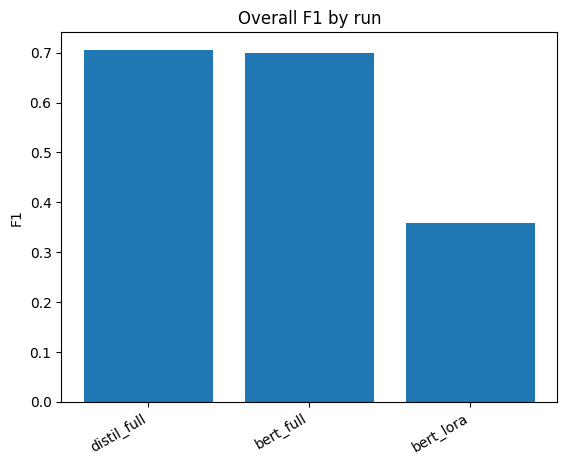

,run,entity,f1,precision,recall,support
0,bert_lora,ERROR,0.000000,0.000000,0.000000,18.0
5,distil_full,ERROR,0.000000,0.000000,0.000000,18.0
10,bert_full,ERROR,0.000000,0.000000,0.000000,18.0
11,bert_full,HARDWARE,0.631579,0.714286,0.566038,53.0
6,distil_full,HARDWARE,0.510638,0.585366,0.452830,53.0
1,bert_lora,HARDWARE,0.000000,0.000000,0.000000,53.0
7,distil_full,OS,0.813793,0.746835,0.893939,66.0
12,bert_full,OS,0.783217,0.727273,0.848485,66.0
2,bert_lora,OS,0.000000,0.000000,0.000000,66.0
8,distil_full,SOFTWARE,0.699125,0.648073,0.758907,842.0


run,bert_full,bert_lora,distil_full
entity,,,
ERROR,0.000000,0.000000,0.000000
HARDWARE,0.631579,0.000000,0.510638
OS,0.783217,0.000000,0.813793
SOFTWARE,0.687661,0.416452,0.699125
VERSION,0.831858,0.000000,0.834123


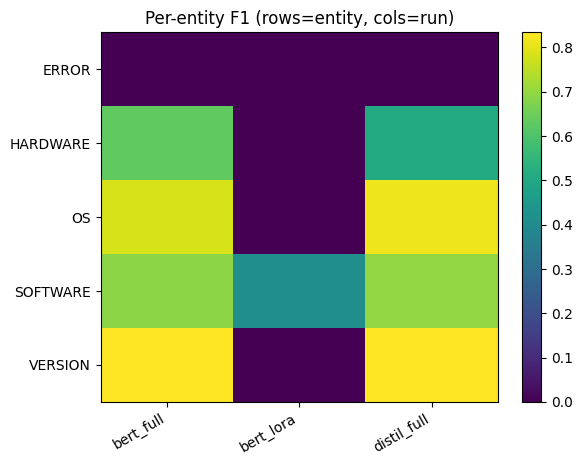

In [8]:
# ===== 7) Compare runs: overall metrics + per-entity F1 =====
rows = []
for r, out in eval_summaries.items():
    o = out["overall"]
    rows.append({"run": r, **o})
df = pd.DataFrame(rows).sort_values("f1", ascending=False)
display(df)

plt.figure()
plt.bar(df["run"], df["f1"])
plt.title("Overall F1 by run")
plt.ylabel("F1")
plt.xticks(rotation=30, ha="right")
plt.show()

# Per-entity table
ent_rows = []
for r, out in eval_summaries.items():
    for ent, m in out["per_entity"].items():
        ent_rows.append({"run": r, "entity": ent, "f1": m.get("f1", 0.0), "precision": m.get("precision", 0.0), "recall": m.get("recall", 0.0), "support": m.get("number", 0.0)})
df_ent = pd.DataFrame(ent_rows)
display(df_ent.sort_values(["entity","f1"], ascending=[True, False]).head(30))

# Heatmap-like pivot (entities x runs)
pivot = df_ent.pivot_table(index="entity", columns="run", values="f1", aggfunc="mean").fillna(0.0)
display(pivot)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Per-entity F1 (rows=entity, cols=run)")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=30, ha="right")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar()
plt.show()


In [9]:
# ===== 8) Error analysis: load errors.json + inspect top confusions =====
from src.paths import read_json

def load_run_json(run, name):
    p = ROOT / "models" / run / name
    return read_json(p)

for r in RUNS:
    err = load_run_json(r, "errors.json")
    conf = pd.DataFrame(err["confusions_topk"])
    print("\n" + "="*80)
    print("RUN:", r)
    display(conf.head(15))



RUN: bert_lora


,true_entity,pred_entity,count
0,SOFTWARE,O,564
1,O,SOFTWARE,182
2,VERSION,O,86
3,OS,SOFTWARE,52
4,ERROR,O,45
5,HARDWARE,O,41
6,VERSION,SOFTWARE,35
7,OS,O,19
8,HARDWARE,SOFTWARE,16
9,ERROR,SOFTWARE,2



RUN: distil_full


,true_entity,pred_entity,count
0,O,SOFTWARE,285
1,SOFTWARE,O,188
2,ERROR,O,45
3,VERSION,O,24
4,HARDWARE,SOFTWARE,20
5,O,HARDWARE,16
6,HARDWARE,O,10
7,O,OS,9
8,SOFTWARE,OS,7
9,OS,SOFTWARE,6



RUN: bert_full


,true_entity,pred_entity,count
0,O,SOFTWARE,365
1,SOFTWARE,O,153
2,ERROR,O,42
3,VERSION,O,17
4,HARDWARE,SOFTWARE,15
5,O,OS,12
6,O,HARDWARE,9
7,OS,SOFTWARE,8
8,O,VERSION,7
9,HARDWARE,O,6


In [10]:
# ===== 9) Qualitative inspection: show worst examples with tokens =====
# We reconstruct token-level view for a few top mismatches.
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

def decode_labels(ids, id2label):
    return [id2label[int(x)] for x in ids]

# pick best run by overall F1
best_run = df.iloc[0]["run"]
print("Best run:", best_run)

run_dir = ROOT / "models" / best_run
tok = AutoTokenizer.from_pretrained(str(run_dir), use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(str(run_dir))
model.eval()

id2label = {i:n for i,n in enumerate(label_names)}

# load top examples indices from errors.json
err = load_run_json(best_run, "errors.json")
top_idxs = [x["idx"] for x in err["examples_topk"][:5]]
print("Top idxs:", top_idxs)

samples = [ds["test"][i] for i in top_idxs]

def predict_one(tokens):
    enc = tok(tokens, is_split_into_words=True, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        out = model(**enc).logits[0].cpu().numpy()
    pred_ids = out.argmax(-1)
    # align back to words via word_ids
    word_ids = enc.word_ids(batch_index=0)
    pred_word = []
    prev = None
    for j, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid != prev:
            pred_word.append(int(pred_ids[j]))
        prev = wid
    return pred_word

for ex in samples:
    tokens = ex["tokens"]
    gold_ids = ex["ner_tags"]
    pred_ids = predict_one(tokens)

    # ensure lengths match (truncate if needed)
    L = min(len(tokens), len(gold_ids), len(pred_ids))
    rows = []
    for i in range(L):
        g = id2label[int(gold_ids[i])]
        p = id2label[int(pred_ids[i])]
        rows.append({"token": tokens[i], "gold": g, "pred": p, "match": (g==p)})

    df_ex = pd.DataFrame(rows)
    print("\n" + "-"*80)
    print("TEXT:", " ".join(tokens[:80]) + (" ..." if len(tokens)>80 else ""))
    display(df_ex[df_ex["match"]==False].head(40))


Best run: distil_full
Top idxs: [2726, 52, 1055, 1563, 2695]

--------------------------------------------------------------------------------
TEXT: I am trying to deploy and test a Universal Windows App to a Surface Pro 3 directly from Visual Studio 2013 ( Update 4) and I am unable to launch the App ( by hitting F 5) .


,token,gold,pred,match
8,Universal,B-SOFTWARE,B-OS,False
9,Windows,I-SOFTWARE,B-OS,False
13,Surface,B-HARDWARE,B-SOFTWARE,False
14,Pro,I-HARDWARE,I-SOFTWARE,False
22,Update,B-VERSION,O,False
23,4),I-VERSION,B-VERSION,False



--------------------------------------------------------------------------------
TEXT: I am using an alarm manager and I have n't been able to maintain the alarms when the system reboots so , I have read that I should use a boot receiver which extends broadcastReceiver but I want to know the exact difference between the receiver itself and the boot receiver .


,token,gold,pred,match
4,alarm,O,B-SOFTWARE,False
5,manager,O,I-SOFTWARE,False
30,boot,O,B-HARDWARE,False
31,receiver,O,I-SOFTWARE,False
49,boot,O,B-HARDWARE,False



--------------------------------------------------------------------------------
TEXT: I checked in the console and I 'm getting an server internal error 500 .. . To make things worse I 've tested whether the post will work with different kinds of titles like : " super duper amoled TV " or something like , and it works. .


,token,gold,pred,match
10,server,B-ERROR,B-SOFTWARE,False
11,internal,I-ERROR,O,False
12,error,I-ERROR,O,False
13,500,I-ERROR,O,False
39,TV,O,B-HARDWARE,False



--------------------------------------------------------------------------------
TEXT: DELETE http://localhost:1693/Product/Delete?id=16 404 ( Not Found )


,token,gold,pred,match
2,404,B-ERROR,O,False
3,(,I-ERROR,O,False
4,Not,I-ERROR,O,False
5,Found,I-ERROR,O,False
6,),I-ERROR,O,False



--------------------------------------------------------------------------------
TEXT: This is the parameter for calendar v2 , I do n't why , but v2 parameter works for public calendar .


,token,gold,pred,match
5,calendar,B-SOFTWARE,O,False
6,v2,B-VERSION,O,False
7,",",I-VERSION,O,False
14,v2,B-VERSION,O,False
19,calendar,B-SOFTWARE,O,False


In [17]:
# ===== 10) ONNX export + INT8 dynamic quantization (exports best for bert_full/distil_full, merges LoRA) =====

import json
import warnings
from pathlib import Path


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*dynamic_axes.*")
warnings.filterwarnings("ignore", message=".*TracerWarning.*")

def _read_json(p: Path):
    return json.loads(p.read_text(encoding="utf-8"))

def _load_label_names(project_root: Path):
    meta_path = project_root / "data" / "processed_meta.json"
    meta = _read_json(meta_path)
    names = meta.get("new_label_names")
    if not names or not isinstance(names, list):
        raise RuntimeError("processed_meta.json missing new_label_names")
    return [str(x) for x in names]

def _best_checkpoint_dir(run_dir: Path) -> Path:
    hist_p = run_dir / "trainer_log_history.json"
    if not hist_p.exists():
        return run_dir
    hist = _read_json(hist_p).get("log_history", [])
    best_loss, best_step = None, None
    for row in hist:
        if "eval_loss" in row and "step" in row:
            loss = float(row["eval_loss"])
            step = int(row["step"])
            if best_loss is None or loss < best_loss:
                best_loss, best_step = loss, step
    if best_step is None:
        return run_dir
    ckpt_root = run_dir / "checkpoints"
    if not ckpt_root.exists():
        return run_dir
    best = None
    best_num = None
    for d in ckpt_root.glob("checkpoint-*"):
        try:
            num = int(d.name.split("-")[-1])
        except Exception:
            continue
        if num == best_step:
            return d
        if best_num is None or abs(num - best_step) < abs(best_num - best_step):
            best, best_num = d, num
    return best or run_dir

def _has_any_model_files(p: Path) -> bool:
    return any((p / f).exists() for f in ["config.json", "model.safetensors", "pytorch_model.bin"])

def _load_model_for_export(src_dir: Path, project_root: Path):
    label_names = _load_label_names(project_root)
    label2id = {n: i for i, n in enumerate(label_names)}
    id2label = {i: n for i, n in enumerate(label_names)}
    num_labels = len(label_names)

    adapter_cfg = src_dir / "adapter_config.json"
    if adapter_cfg.exists():
        from peft import PeftConfig, PeftModel
        peft_cfg = PeftConfig.from_pretrained(str(src_dir))
        base_name = peft_cfg.base_model_name_or_path

        base = AutoModelForTokenClassification.from_pretrained(
            base_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
        )
        peft_model = PeftModel.from_pretrained(base, str(src_dir))
        if hasattr(peft_model, "merge_and_unload"):
            model = peft_model.merge_and_unload()
        else:
            model = peft_model
        return model

    if not _has_any_model_files(src_dir):
        raise FileNotFoundError(f"No model files found in: {src_dir}")

    model = AutoModelForTokenClassification.from_pretrained(
        str(src_dir),
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    return model

def export_onnx_and_int8(src_dir: Path, out_dir: Path, project_root: Path, seq_len=128, opset=18):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    tok = AutoTokenizer.from_pretrained(str(src_dir), use_fast=True)
    model = _load_model_for_export(src_dir, project_root)
    model.eval().cpu()

    dummy = tok(
        ["hello world"],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=int(seq_len),
    )

    inputs = [dummy["input_ids"]]
    input_names = ["input_ids"]
    dynamic_axes = {"input_ids": {0: "batch", 1: "seq"}}

    if "attention_mask" in dummy:
        inputs.append(dummy["attention_mask"])
        input_names.append("attention_mask")
        dynamic_axes["attention_mask"] = {0: "batch", 1: "seq"}

    if "token_type_ids" in dummy:
        inputs.append(dummy["token_type_ids"])
        input_names.append("token_type_ids")
        dynamic_axes["token_type_ids"] = {0: "batch", 1: "seq"}

    onnx_fp32 = out_dir / "model.onnx"
    torch.onnx.export(
        model,
        tuple(inputs),
        f=str(onnx_fp32),
        input_names=input_names,
        output_names=["logits"],
        dynamic_axes={**dynamic_axes, "logits": {0: "batch", 1: "seq"}},
        opset_version=int(opset),
        do_constant_folding=True,
        dynamo=False,
    )

    from onnxruntime.quantization import quantize_dynamic, QuantType

    onnx_int8 = out_dir / "model.int8.onnx"
    quantize_dynamic(
        model_input=str(onnx_fp32),
        model_output=str(onnx_int8),
        weight_type=QuantType.QInt8,
    )

    tok.save_pretrained(str(out_dir))
    return {"onnx_fp32": str(onnx_fp32), "onnx_int8": str(onnx_int8), "out_dir": str(out_dir)}

def export_best_for_runs(project_root: Path, runs, seq_len=128, opset=18):
    project_root = Path(project_root)
    results = {}

    for run in runs:
        run_dir = project_root / "models" / run
        best_dir = _best_checkpoint_dir(run_dir)

        if (run_dir / "adapter_config.json").exists():
            export_src = run_dir
        else:
            export_src = best_dir if _has_any_model_files(best_dir) else run_dir

        if not (export_src / "adapter_config.json").exists() and not _has_any_model_files(export_src):
            raise FileNotFoundError(f"[{run}] no exportable model found in {export_src}")

        out_dir = project_root / "exports" / run

        print(f"[{run}] best_dir   = {best_dir}")
        print(f"[{run}] export_src = {export_src}")

        res = export_onnx_and_int8(
            src_dir=export_src,
            out_dir=out_dir,
            project_root=project_root,
            seq_len=seq_len,
            opset=opset,
        )
        results[run] = {"best_dir": str(best_dir), "export_src": str(export_src), **res}
        print(f"[{run}] OK -> {out_dir}\n")

    return results

RUNS = ["bert_full", "bert_lora", "distil_full"]
export_results = export_best_for_runs(Path(ROOT), RUNS, seq_len=128, opset=18)
export_results

[bert_full] best_dir   = C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full\checkpoints\checkpoint-1158
[bert_full] export_src = C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_full\checkpoints\checkpoint-1158


C:\Users\alenk\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


[bert_full] OK -> C:\Users\alenk\Downloads\it-ner-peft-compression\exports\bert_full

[bert_lora] best_dir   = C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora\checkpoints\checkpoint-2895
[bert_lora] export_src = C:\Users\alenk\Downloads\it-ner-peft-compression\models\bert_lora


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[bert_lora] OK -> C:\Users\alenk\Downloads\it-ner-peft-compression\exports\bert_lora

[distil_full] best_dir   = C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full\checkpoints\checkpoint-1158
[distil_full] export_src = C:\Users\alenk\Downloads\it-ner-peft-compression\models\distil_full\checkpoints\checkpoint-1158


[distil_full] OK -> C:\Users\alenk\Downloads\it-ner-peft-compression\exports\distil_full



{'bert_full': {'best_dir': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_full\\checkpoints\\checkpoint-1158',
  'export_src': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_full\\checkpoints\\checkpoint-1158',
  'onnx_fp32': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\exports\\bert_full\\model.onnx',
  'onnx_int8': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\exports\\bert_full\\model.int8.onnx',
  'out_dir': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\exports\\bert_full'},
 'bert_lora': {'best_dir': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_lora\\checkpoints\\checkpoint-2895',
  'export_src': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\models\\bert_lora',
  'onnx_fp32': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\exports\\bert_lora\\model.onnx',
  'onnx_int8': 'C:\\Users\\alenk\\Downloads\\it-ner-peft-compression\\exports\\bert_lora\\model.int8.onnx',
  'out_dir':

# Training Analytics & Visualizations

This section reads artifacts saved under `models/` and builds a compact dashboard: run summaries, loss curves, learning-rate curves, and dataset diagnostics.

> It won’t overwrite your saved results. It only *reads* JSON artifacts and (optionally) loads models for extra evaluation.

In [23]:
# --- Imports (analytics) ---
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().resolve().parent

MODELS_DIR = ROOT / "models"
DATA_DIR = ROOT / "data"
EXPORTS_DIR = ROOT / "exports"

ROOT, MODELS_DIR, DATA_DIR, EXPORTS_DIR


(WindowsPath('C:/Users/alenk/Downloads/it-ner-peft-compression'),
 WindowsPath('C:/Users/alenk/Downloads/it-ner-peft-compression/models'),
 WindowsPath('C:/Users/alenk/Downloads/it-ner-peft-compression/data'),
 WindowsPath('C:/Users/alenk/Downloads/it-ner-peft-compression/exports'))

In [24]:
# --- Small helpers ---
def read_json(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def maybe(p: Path):
    return p if p.exists() else None

def list_run_dirs(models_dir: Path):
    if not models_dir.exists():
        return []
    dirs = [d for d in models_dir.iterdir() if d.is_dir()]
    def key(d: Path):
        name = d.name
        is_backup = "__backup__" in name
        return (is_backup, name)
    return sorted(dirs, key=key)

run_dirs = list_run_dirs(MODELS_DIR)
[r.name for r in run_dirs], len(run_dirs)


(['bert_full', 'bert_lora', 'distil_full', 'onnx', 'tmp_merged_lora'], 5)

In [25]:
# ===== Load run summaries into a table (safe) =====
rows = []

run_dirs = list_run_dirs(MODELS_DIR)

for d in run_dirs:
    cfg = maybe(d / "config_resolved.json")
    met = maybe(d / "metrics_train.json")
    hist = maybe(d / "trainer_log_history.json")
    met2 = maybe(d / "metrics.json")

    row = {"run_dir": str(d), "run_name": d.name}

    if cfg is not None:
        c = read_json(cfg)
        row.update({
            "run": c.get("run", d.name),
            "base_model": c.get("base_model"),
            "use_lora": c.get("use_lora"),
            "epochs": c.get("epochs"),
            "batch_size": c.get("batch_size"),
            "grad_accum": c.get("grad_accum"),
            "effective_batch": c.get("effective_batch"),
            "fp16": c.get("fp16"),
            "tf32": c.get("tf32"),
            "max_length": c.get("max_length"),
            "dataset": c.get("dataset"),
        })

    if met is not None:
        m = read_json(met)
        tr = m.get("train", {}) or {}
        ev = m.get("eval", {}) or {}
        row.update({
            "train_loss": tr.get("train_loss"),
            "train_runtime": tr.get("train_runtime"),
            "train_samples_per_second": tr.get("train_samples_per_second"),
            "eval_loss": ev.get("eval_loss"),
            "eval_runtime": ev.get("eval_runtime"),
        })

    if met2 is not None and (row.get("eval_loss") is None):
        m2 = read_json(met2)
        for k in ["eval_loss", "eval_f1", "eval_precision", "eval_recall"]:
            if k in m2:
                row[k] = m2.get(k)

    row["has_history"] = bool(hist is not None)
    rows.append(row)

df_runs = pd.DataFrame(rows)

if df_runs.empty:
    df_runs = pd.DataFrame([{
        "run_dir": str(MODELS_DIR),
        "run_name": None,
        "note": "No runs found. Check ROOT/MODELS_DIR points to your project root and that models/<run>/ exists."
    }])
else:
    cols = [c for c in [
        "run_name","run","base_model","use_lora","epochs","batch_size","grad_accum","effective_batch",
        "eval_loss","train_loss","fp16","tf32","dataset","run_dir","has_history"
    ] if c in df_runs.columns]
    df_runs = df_runs[cols]
    if "run_name" in df_runs.columns:
        df_runs = df_runs.sort_values(by=["run_name"]).reset_index(drop=True)

df_runs


,run_name,run,base_model,use_lora,epochs,batch_size,grad_accum,effective_batch,eval_loss,train_loss,fp16,tf32,dataset,run_dir,has_history
0,bert_full,bert_full,bert-base-cased,False,5.0,8.0,2.0,16.0,0.067200,0.063605,True,True,mrm8488/stackoverflow-ner,C:\Users\alenk\Downloads\it-ner-peft-compressi...,True
1,bert_lora,bert_lora,bert-base-cased,True,5.0,8.0,2.0,16.0,0.113613,0.265732,True,True,mrm8488/stackoverflow-ner,C:\Users\alenk\Downloads\it-ner-peft-compressi...,True
2,distil_full,distil_full,distilbert-base-cased,False,5.0,8.0,2.0,16.0,0.068480,0.070224,True,True,mrm8488/stackoverflow-ner,C:\Users\alenk\Downloads\it-ner-peft-compressi...,True
3,onnx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\alenk\Downloads\it-ner-peft-compressi...,False
4,tmp_merged_lora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\alenk\Downloads\it-ner-peft-compressi...,False


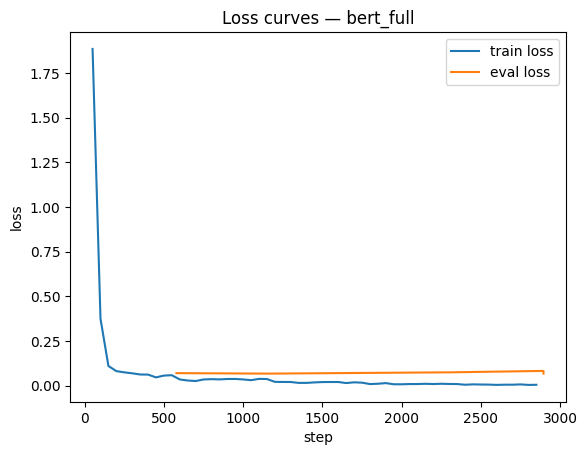

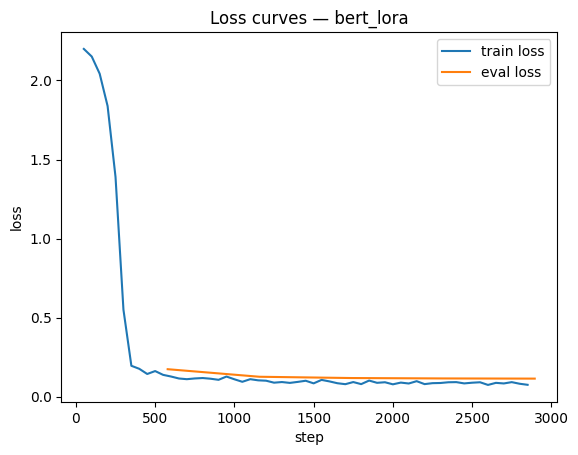

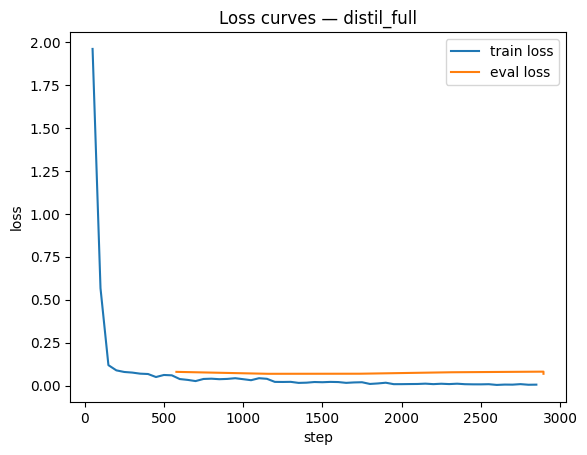

In [26]:
# --- Plot: Train loss & Eval loss over time (per run) ---
def parse_history(hist_json):
    # hist_json: {"log_history": [...]}
    h = hist_json.get("log_history", [])
    df = pd.DataFrame(h)
    return df

def plot_loss_curves(run_dir: Path):
    hist_p = run_dir / "trainer_log_history.json"
    if not hist_p.exists():
        return
    df = parse_history(read_json(hist_p))
    if df.empty:
        return

    # train loss
    train_df = df[df.get("loss").notna()] if "loss" in df.columns else pd.DataFrame()
    eval_df = df[df.get("eval_loss").notna()] if "eval_loss" in df.columns else pd.DataFrame()

    plt.figure()
    if not train_df.empty:
        x = train_df["step"] if "step" in train_df.columns else np.arange(len(train_df))
        plt.plot(x, train_df["loss"], label="train loss")
    if not eval_df.empty:
        x = eval_df["step"] if "step" in eval_df.columns else np.arange(len(eval_df))
        plt.plot(x, eval_df["eval_loss"], label="eval loss")
    plt.title(f"Loss curves — {run_dir.name}")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

for d in run_dirs:
    plot_loss_curves(d)


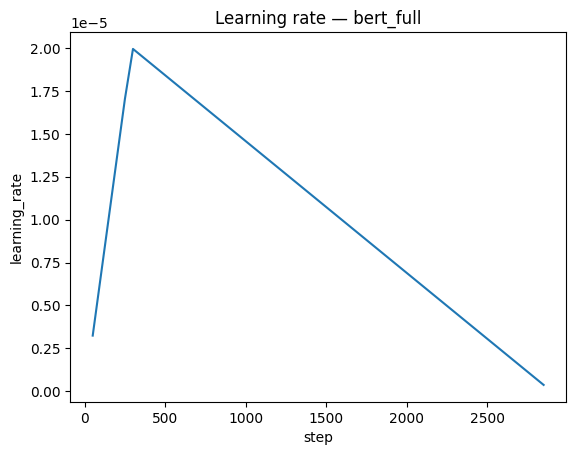

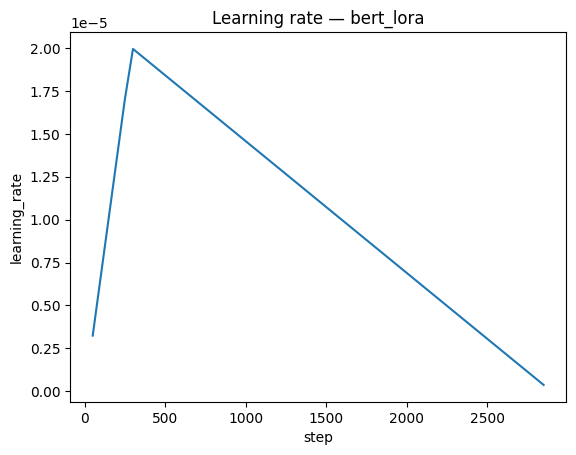

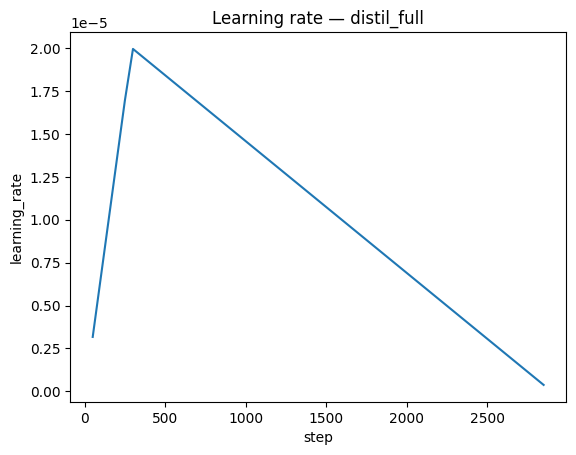

In [27]:
# --- Plot: Learning rate schedule (per run) ---
def plot_lr(run_dir: Path):
    hist_p = run_dir / "trainer_log_history.json"
    if not hist_p.exists():
        return
    df = parse_history(read_json(hist_p))
    if df.empty or "learning_rate" not in df.columns:
        return

    lr_df = df[df["learning_rate"].notna()]
    if lr_df.empty:
        return

    plt.figure()
    x = lr_df["step"] if "step" in lr_df.columns else np.arange(len(lr_df))
    plt.plot(x, lr_df["learning_rate"])
    plt.title(f"Learning rate — {run_dir.name}")
    plt.xlabel("step")
    plt.ylabel("learning_rate")
    plt.show()

for d in run_dirs:
    plot_lr(d)


## Dataset diagnostics

These cells look at your processed dataset on disk (so you don't need to re-download/re-process).

In [28]:
# --- Load processed dataset + meta (if present) ---
from datasets import load_from_disk

meta_p = DATA_DIR / "processed_meta.json"
meta = read_json(meta_p) if meta_p.exists() else {}
meta.keys()


dict_keys(['dataset', 'tag_mode', 'new_label_names', 'new_num_labels', 'mapping_coverage', 'weak_data', 'oversampling', 'eda', 'domain_adaptation'])

In [29]:
# --- Basic dataset stats + label distribution ---
# Adjust the dataset folder name if yours differs.
def ds_key(dataset_name: str) -> str:
    # matches your project helper: replace / with __
    return dataset_name.replace("/", "__")

dataset_name = meta.get("dataset_name") or meta.get("dataset") or "mrm8488/stackoverflow-ner"
proc_dir = DATA_DIR / "processed" / ds_key(dataset_name)

ds = load_from_disk(str(proc_dir))
ds


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9263
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2936
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3108
    })
})

In [30]:
# Count label ids in train split
label_names = meta.get("new_label_names") or meta.get("label_names")
assert label_names is not None, "No label names found in processed_meta.json"
label_names = list(map(str, label_names))

train = ds["train"]
all_tags = []
for tags in train["ner_tags"]:
    all_tags.extend(tags)

counts = pd.Series(all_tags).value_counts().sort_index()
lab = pd.DataFrame({"label_id": counts.index, "count": counts.values})
lab["label_name"] = lab["label_id"].apply(lambda i: label_names[int(i)] if int(i) < len(label_names) else f"ID_{i}")
lab = lab.sort_values("count", ascending=False).reset_index(drop=True)
lab.head(20)


,label_id,count,label_name
0,0,132983,O
1,4,2766,B-SOFTWARE
2,9,422,I-SOFTWARE
3,5,257,B-VERSION
4,2,199,B-HARDWARE
5,3,171,B-OS
6,1,61,B-ERROR
7,6,53,I-ERROR
8,7,46,I-HARDWARE
9,8,21,I-OS


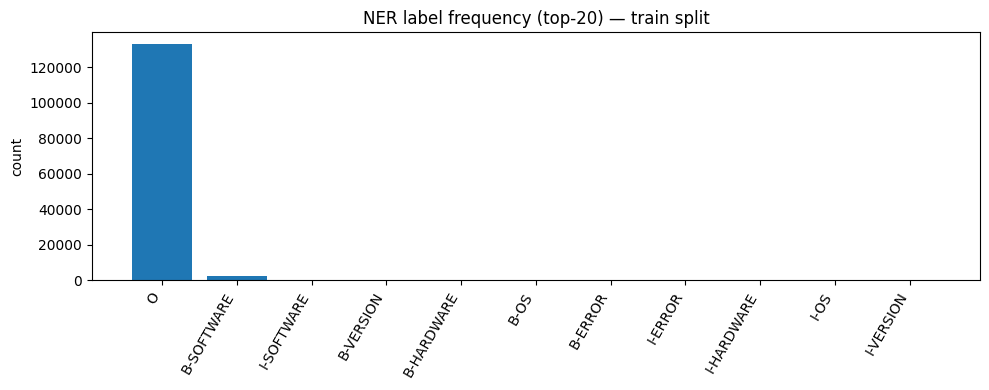

In [31]:
# Plot label distribution (top-20)
topk = 20
lab_top = lab.head(topk)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(lab_top)), lab_top["count"].values)
plt.xticks(np.arange(len(lab_top)), lab_top["label_name"].values, rotation=60, ha="right")
plt.title("NER label frequency (top-20) — train split")
plt.ylabel("count")
plt.tight_layout()
plt.show()


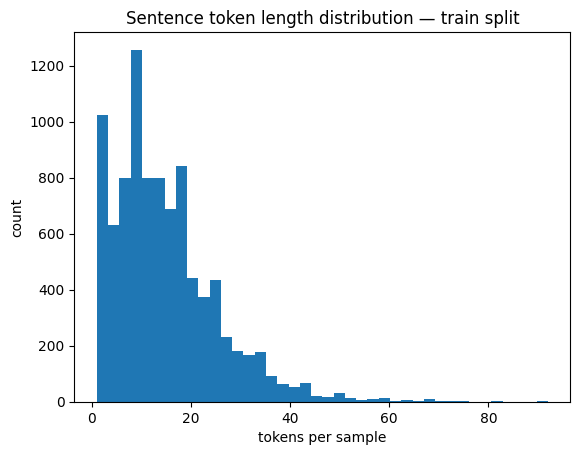

count    9263.000000
mean       14.789593
std        10.521445
min         1.000000
25%         7.000000
50%        13.000000
75%        20.000000
max        92.000000
dtype: float64

In [32]:
# Token-length distribution (how many tokens per sentence)
lens = [len(toks) for toks in train["tokens"]]
plt.figure()
plt.hist(lens, bins=40)
plt.title("Sentence token length distribution — train split")
plt.xlabel("tokens per sample")
plt.ylabel("count")
plt.show()

pd.Series(lens).describe()


## Optional: richer NER metrics (F1/precision/recall)

If you want F1 (seqeval), run this. It loads each saved model and evaluates on the validation split.

> This does **not** change your saved training artifacts — it only computes extra metrics in-memory.

In [33]:
# ===== Extra eval (seqeval) for saved runs =====
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

def _safe_word_ids(tokenizer, tokens, max_length=128):
    enc = tokenizer(tokens, is_split_into_words=True, truncation=True, max_length=max_length)
    try:
        return enc.word_ids()
    except TypeError:
        return enc.word_ids(batch_index=0)

def eval_seqeval(run_dir: Path, ds, label_names, split="validation", max_length=128):
    model_dir = Path(run_dir)
    if not (model_dir / "config.json").exists():
        return None

    tokenizer = AutoTokenizer.from_pretrained(str(model_dir), use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(str(model_dir))
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    ds_split = ds[split] if split in ds else (ds["test"] if "test" in ds else None)
    if ds_split is None:
        return None

    y_true, y_pred = [], []
    for i in range(len(ds_split)):
        tokens = ds_split[i]["tokens"]
        labels = ds_split[i]["ner_tags"]

        enc = tokenizer(tokens, is_split_into_words=True, truncation=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits[0].detach().cpu().numpy()

        pred_ids = logits.argmax(-1).tolist()
        word_ids = _safe_word_ids(tokenizer, tokens, max_length=max_length)

        true_seq, pred_seq = [], []
        prev_wid = None
        for j, wid in enumerate(word_ids):
            if wid is None or wid == prev_wid:
                prev_wid = wid
                continue
            prev_wid = wid
            true_seq.append(label_names[int(labels[wid])])
            pid = int(pred_ids[j]) if j < len(pred_ids) else 0
            pred_seq.append(label_names[pid] if 0 <= pid < len(label_names) else "O")

        y_true.append(true_seq)
        y_pred.append(pred_seq)

    return {
        "f1": float(f1_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "report": classification_report(y_true, y_pred, digits=4),
    }

run_dirs = sorted([p for p in Path(ROOT / "models").iterdir() if p.is_dir()])
extra_rows = []

for d in run_dirs:
    out = eval_seqeval(d, ds=ds, label_names=label_names, split="validation", max_length=128)
    if out:
        extra_rows.append({"run": d.name, "f1": out["f1"], "precision": out["precision"], "recall": out["recall"]})
        print(f"=== {d.name} ===")
        print(out["report"][:1200] + ("\n..." if len(out["report"]) > 1200 else ""))

pd.DataFrame(extra_rows).sort_values("f1", ascending=False).reset_index(drop=True) if extra_rows else "No runnable models found."

=== bert_full ===
              precision    recall  f1-score   support

       ERROR     0.0000    0.0000    0.0000        35
    HARDWARE     0.7391    0.4564    0.5643       149
          OS     0.7532    0.7945    0.7733        73
    SOFTWARE     0.6308    0.8297    0.7167       863
     VERSION     0.7635    0.8188    0.7902       138

   micro avg     0.6577    0.7591    0.7048      1258
   macro avg     0.5773    0.5799    0.5689      1258
weighted avg     0.6478    0.7591    0.6901      1258

=== distil_full ===
              precision    recall  f1-score   support

       ERROR     0.0000    0.0000    0.0000        35
    HARDWARE     0.6628    0.3826    0.4851       149
          OS     0.6170    0.7945    0.6946        73
    SOFTWARE     0.6359    0.7833    0.7020       863
     VERSION     0.8254    0.7536    0.7879       138

   micro avg     0.6538    0.7114    0.6814      1258
   macro avg     0.5482    0.5428    0.5339      1258
weighted avg     0.6411    0.7114    0.

,run,f1,precision,recall
0,bert_full,0.704797,0.657713,0.759141
1,distil_full,0.681386,0.653762,0.711447
